# Graph - Optimization
https://dask.pydata.org/en/latest/optimize.html

In [1]:
import dask
from dask import visualize

In [2]:
from __future__ import print_function

def print_and_return(string):
    print(string)
    return string

def format_str(count, val, nwords):
    return ('word list has {0} occurrences of {1}, '
            'out of {2} words').format(count, val, nwords)

dsk = {'words': 'apple orange apple pear orange pear pear',
       'nwords': (len, (str.split, 'words')),
       'val1': 'orange',
       'val2': 'apple',
       'val3': 'pear',
       'count1': (str.count, 'words', 'val1'),
       'count2': (str.count, 'words', 'val2'),
       'count3': (str.count, 'words', 'val3'),
       'out1': (format_str, 'count1', 'val1', 'nwords'),
       'out2': (format_str, 'count2', 'val2', 'nwords'),
       'out3': (format_str, 'count3', 'val3', 'nwords'),
       'print1': (print_and_return, 'out1'),
       'print2': (print_and_return, 'out2'),
       'print3': (print_and_return, 'out3')}

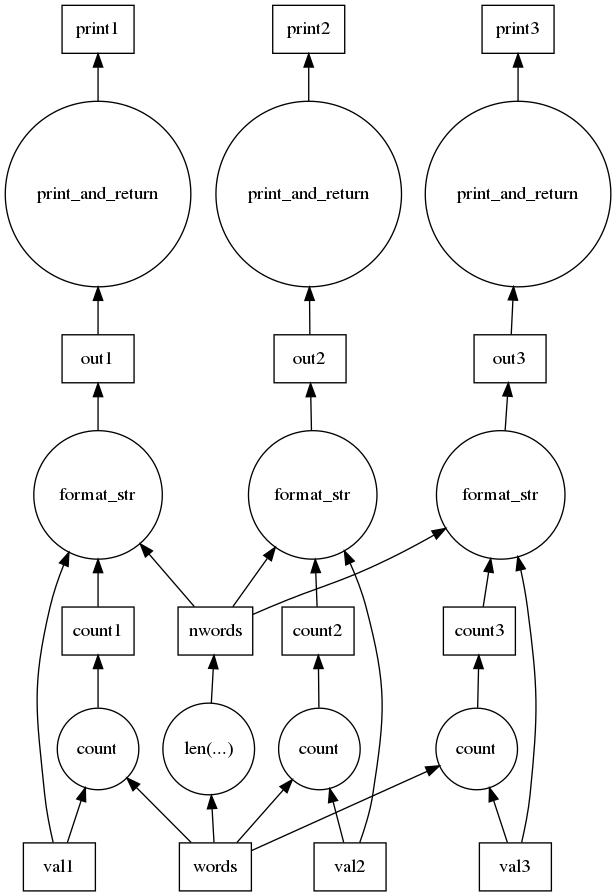

In [3]:
visualize(dsk)

In [4]:
from dask.threaded import get

outputs = ['print1', 'print2']
results = get(dsk, outputs)
results

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


('word list has 2 occurrences of orange, out of 7 words',
 'word list has 2 occurrences of apple, out of 7 words')

## Removed tasks unnecessary for the desired output using cull.

In [5]:
from dask.optimization import cull
dsk1, dependencies = cull(dsk, outputs)

In [6]:
dsk1

{'count1': (<method 'count' of 'str' objects>, 'words', 'val1'),
 'count2': (<method 'count' of 'str' objects>, 'words', 'val2'),
 'nwords': (<function len>, (<method 'split' of 'str' objects>, 'words')),
 'out1': (<function __main__.format_str>, 'count1', 'val1', 'nwords'),
 'out2': (<function __main__.format_str>, 'count2', 'val2', 'nwords'),
 'print1': (<function __main__.print_and_return>, 'out1'),
 'print2': (<function __main__.print_and_return>, 'out2'),
 'val1': 'orange',
 'val2': 'apple',
 'words': 'apple orange apple pear orange pear pear'}

In [7]:
dependencies

{'count1': ['words', 'val1'],
 'count2': ['words', 'val2'],
 'nwords': ['words'],
 'out1': ['count1', 'val1', 'nwords'],
 'out2': ['count2', 'val2', 'nwords'],
 'print1': ['out1'],
 'print2': ['out2'],
 'val1': [],
 'val2': [],
 'words': []}

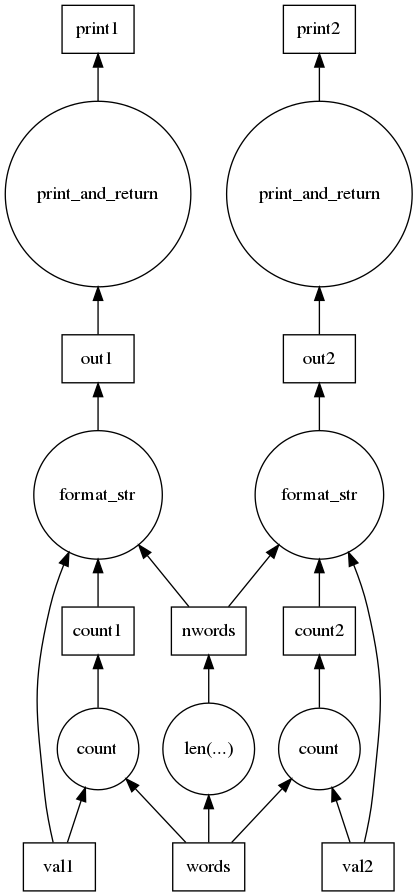

In [8]:
visualize(dsk1)

## Inlined constants using inline.

In [9]:
from dask.optimization import inline
dsk2 = inline(dsk1, dependencies=dependencies)
results = get(dsk2, outputs)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


In [10]:
dsk2

{'count1': (<method 'count' of 'str' objects>,
  'apple orange apple pear orange pear pear',
  'orange'),
 'count2': (<method 'count' of 'str' objects>,
  'apple orange apple pear orange pear pear',
  'apple'),
 'nwords': (<function len>,
  (<method 'split' of 'str' objects>,
   'apple orange apple pear orange pear pear')),
 'out1': (<function __main__.format_str>, 'count1', 'orange', 'nwords'),
 'out2': (<function __main__.format_str>, 'count2', 'apple', 'nwords'),
 'print1': (<function __main__.print_and_return>, 'out1'),
 'print2': (<function __main__.print_and_return>, 'out2'),
 'val1': 'orange',
 'val2': 'apple',
 'words': 'apple orange apple pear orange pear pear'}

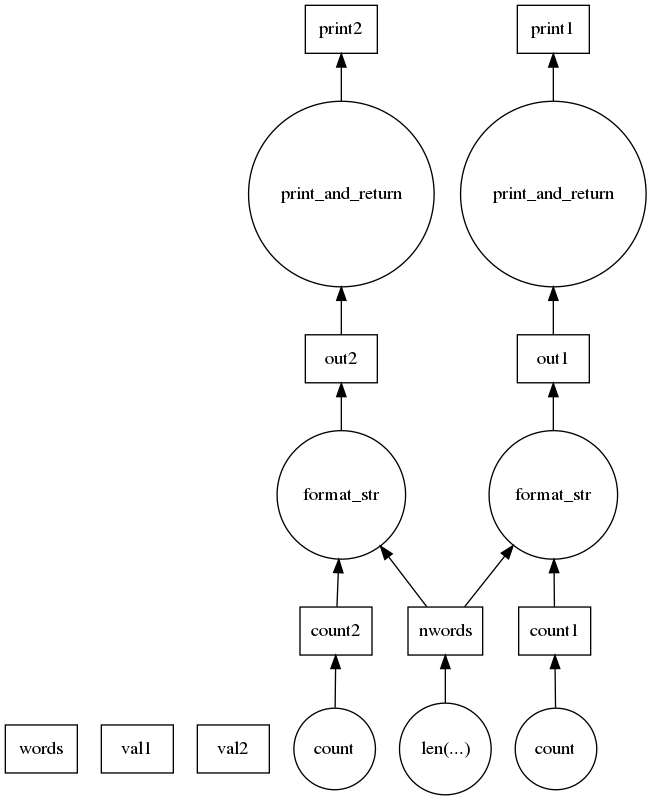

In [11]:
visualize(dsk2)

## Inlined cheap computations using inline_functions, improving parallelism.

In [12]:
from dask.optimization import inline_functions
dsk3 = inline_functions(dsk2, outputs, [len, str.split],
                        dependencies=dependencies)
results = get(dsk3, outputs)

word list has 2 occurrences of apple, out of 7 words
word list has 2 occurrences of orange, out of 7 words


In [13]:
dsk3

{'count1': (<method 'count' of 'str' objects>,
  'apple orange apple pear orange pear pear',
  'orange'),
 'count2': (<method 'count' of 'str' objects>,
  'apple orange apple pear orange pear pear',
  'apple'),
 'out1': (<function __main__.format_str>,
  'count1',
  'orange',
  (<function len>,
   (<method 'split' of 'str' objects>,
    'apple orange apple pear orange pear pear'))),
 'out2': (<function __main__.format_str>,
  'count2',
  'apple',
  (<function len>,
   (<method 'split' of 'str' objects>,
    'apple orange apple pear orange pear pear'))),
 'print1': (<function __main__.print_and_return>, 'out1'),
 'print2': (<function __main__.print_and_return>, 'out2'),
 'val1': 'orange',
 'val2': 'apple',
 'words': 'apple orange apple pear orange pear pear'}

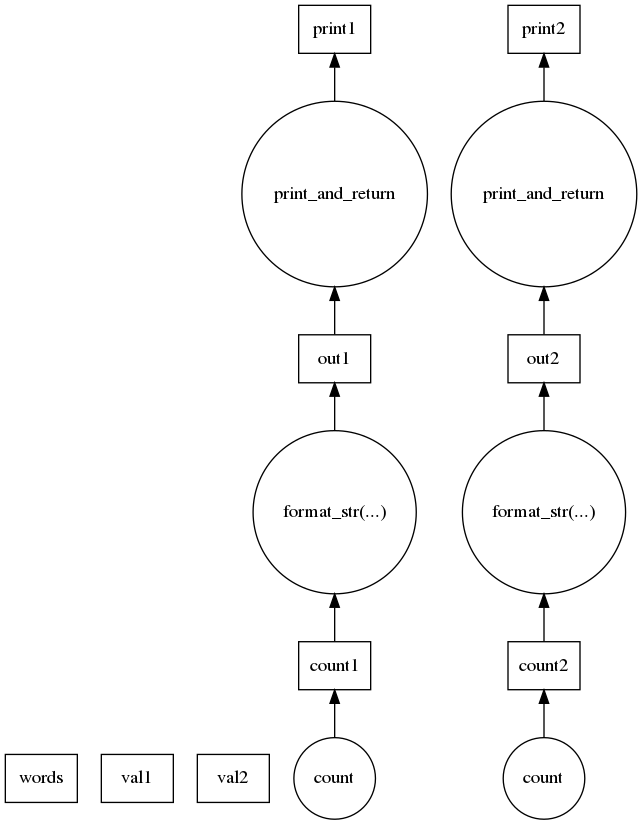

In [14]:
visualize(dsk3)

## Fused linear tasks together to ensure they run on the same worker using fuse.


In [15]:
from dask.optimization import fuse

dsk4, dependencies = fuse(dsk3)
results = get(dsk4, outputs)

word list has 2 occurrences of apple, out of 7 words
word list has 2 occurrences of orange, out of 7 words


In [16]:
dsk4

{'count1-out1-print1': (<function __main__.print_and_return>,
  (<function __main__.format_str>,
   (<method 'count' of 'str' objects>,
    'apple orange apple pear orange pear pear',
    'orange'),
   'orange',
   (<function len>,
    (<method 'split' of 'str' objects>,
     'apple orange apple pear orange pear pear')))),
 'count2-out2-print2': (<function __main__.print_and_return>,
  (<function __main__.format_str>,
   (<method 'count' of 'str' objects>,
    'apple orange apple pear orange pear pear',
    'apple'),
   'apple',
   (<function len>,
    (<method 'split' of 'str' objects>,
     'apple orange apple pear orange pear pear')))),
 'print1': 'count1-out1-print1',
 'print2': 'count2-out2-print2',
 'val1': 'orange',
 'val2': 'apple',
 'words': 'apple orange apple pear orange pear pear'}

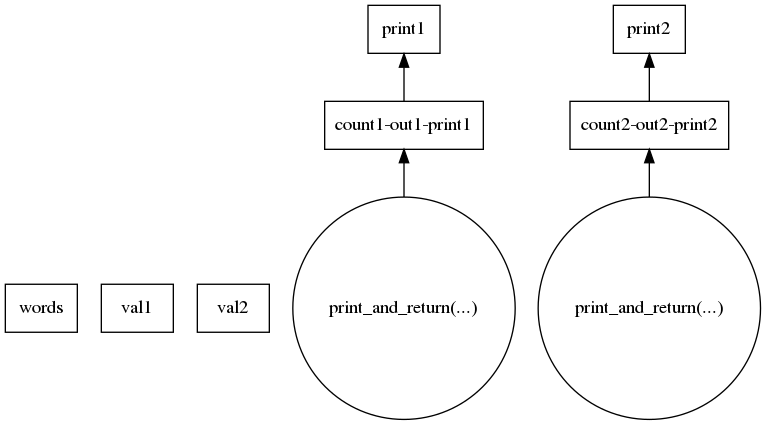

In [17]:
visualize(dsk4)

### Putting it all together:

In [18]:
def optimize_and_get(dsk, keys):
    dsk1, deps = cull(dsk, keys)
    dsk2 = inline(dsk1, dependencies=deps)
    dsk3 = inline_functions(dsk2, keys, [len, str.split],
                            dependencies=deps)
    dsk4, deps = fuse(dsk3)
    return get(dsk4, keys)

optimize_and_get(dsk, outputs)

word list has 2 occurrences of apple, out of 7 words
word list has 2 occurrences of orange, out of 7 words


('word list has 2 occurrences of orange, out of 7 words',
 'word list has 2 occurrences of apple, out of 7 words')

# Rewrite Rules
For context based optimizations, dask.rewrite provides functionality for pattern matching and term rewriting. This is useful for **replacing expensive computations with equivalent, cheaper computations**. For example, dask.array uses the rewrite functionality to replace series of array slicing operations with a more efficient single slice.

## Example

In [19]:
from dask.rewrite import RewriteRule, RuleSet
from operator import add, mul, pow

variables = ('a',)
rule1 = RewriteRule((add, 'a', 'a'), (mul, 'a', 2), variables)
rule2 = RewriteRule((mul, 'a', 'a'), (pow, 'a', 2), variables)
rs = RuleSet(rule1, rule2)

In [20]:
rule1

RewriteRule((<built-in function add>, 'a', 'a'), (<built-in function mul>, 'a', 2), ('a',))

In [21]:
rs.rewrite((add, 5, 5))

(<function _operator.mul>, 5, 2)

In [22]:
rs.rewrite((mul, 5, 5))

(<function _operator.pow>, 5, 2)

In [23]:
rs.rewrite((mul, (add, 3, 3), (add, 3, 3)))

(<function _operator.pow>, (<function _operator.mul>, 3, 2), 2)

In [24]:
# Transforms whole task
rs.rewrite((sum, [(add, 3, 3), (mul, 3, 3)])) 

(<function sum>,
 [(<function _operator.mul>, 3, 2), (<function _operator.pow>, 3, 2)])

In [25]:
# Only applies to top level, no transform occurs
rs.rewrite((sum, [(add, 3, 3), (mul, 3, 3)]), strategy='top_level') 

(<function sum>,
 [(<function _operator.add>, 3, 3), (<function _operator.mul>, 3, 3)])

# Keyword Arguments
Some optimizations take optional keyword arguments. To pass keywords from the compute call down to the right optimization, prepend the keyword with the name of the optimization. For example to send a `keys= keyword` argument to the fuse optimization from a compute call, use the `fuse_keys= keyword`:

# Customizing Optimization
Dask defines a default optimization strategy for each collection type (Array, Bag, DataFrame, Delayed). However different applications may have different needs. To address this variability of needs, you can construct your own custom optimization function and use it instead of the default. An optimization function takes in a task graph and list of desired keys and returns a new task graph.

In [26]:
def my_optimize_function(dsk, keys):
    new_dsk = {...}
    return new_dsk

In [27]:
def my_other_optimize_function(dsk, keys):
    new_dsk = {...}
    return new_dsk

You can then register this optimization class against whichever collection type you prefer and it will be used instead of the default scheme.

In [28]:
with dask.set_options(array_optimize=my_optimize_function):
    x = 1
    y = 2
    x, y = dask.compute(x, y)

You can register separate optimization functions for different collections, or you can register `None` if you do not want particular types of collections to be optimized.

In [29]:
with dask.set_options(array_optimize=my_optimize_function,
                      dataframe_optimize=None,
                      delayed_optimize=my_other_optimize_function):
    pass